In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medianhouseprice/MSPUS.csv


Reference:
Tensorflow tutorials
https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [2]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize']=(8,6)
mpl.rcParams['axes.grid']=False

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.metrics import mean_absolute_percentage_error

from keras.layers import *
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [3]:
df=pd.read_csv('/kaggle/input/medianhouseprice/MSPUS.csv')

In [4]:
rows,columns=df.shape[0],df.shape[1]
print(rows,columns)

237 2


In [5]:
df['DATE']=pd.to_datetime(df['DATE'])
df.set_index('DATE',inplace=True)

In [6]:
df.head()

,MSPUS
DATE,
1963-01-01,17800.0
1963-04-01,18000.0
1963-07-01,17900.0
1963-10-01,18500.0
1964-01-01,18500.0


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MSPUS,237.0,143973.417722,103386.305,17800.0,51600.0,125000.0,224300.0,428700.0


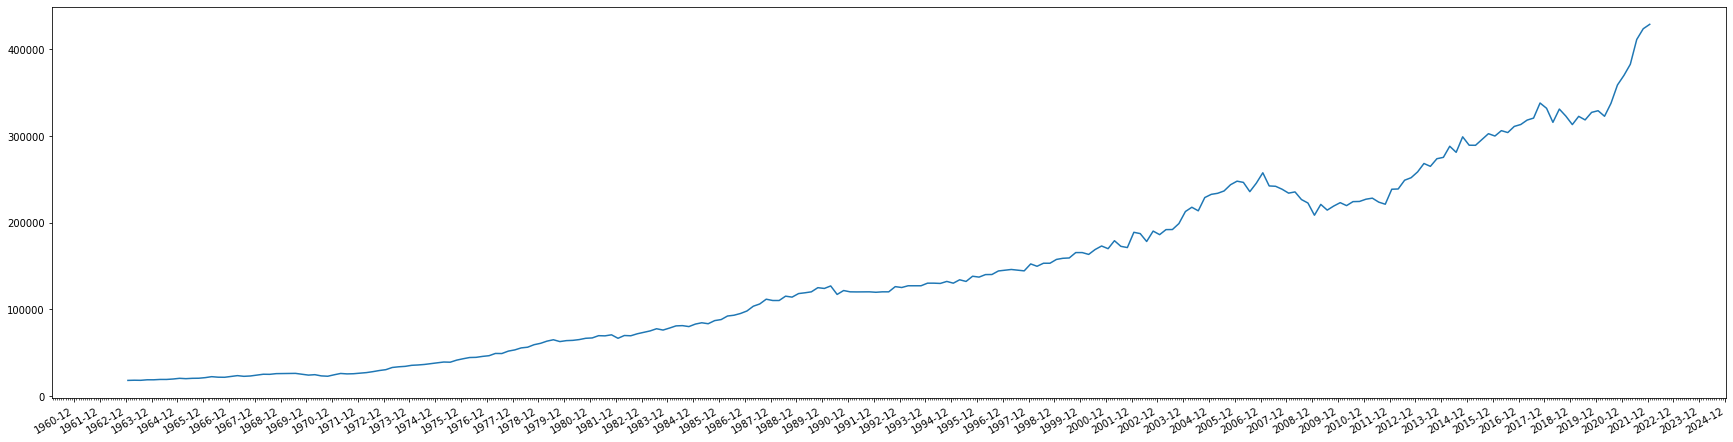

In [8]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(30, 8))

monthly_locator = mdates.MonthLocator()
year_locator = mdates.MonthLocator(12)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_minor_locator(monthly_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.plot(df.index, df.MSPUS)

fig.autofmt_xdate()


In [9]:
# Check stationarity of the data
def adf_test(timeseries):
    print("Results of Augmented Dickey-fuller test")
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key]= value
    print(dfoutput)

In [10]:
df['first_diff']=df['MSPUS'].diff(periods=1)
df.head()

,MSPUS,first_diff
DATE,,
1963-01-01,17800.0,NaN
1963-04-01,18000.0,200.0
1963-07-01,17900.0,-100.0
1963-10-01,18500.0,600.0
1964-01-01,18500.0,0.0


In [11]:
adf_test(df.first_diff.dropna())

Results of Augmented Dickey-fuller test
Test Statistic                  -2.901239
p-value                          0.045204
#lags used                      11.000000
number of observations used    224.000000
critical value (1%)             -3.459885
critical value (5%)             -2.874531
critical value (10%)            -2.573694
dtype: float64


P-Value is at the border . Its less than 0.05 but not much so that we can decide about wether the series is stationary or not.

In [12]:
# Check KPSS test
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [13]:
kpss_test(df.first_diff.dropna())

Results of KPSS Test:
Test Statistic           0.621725
p-value                  0.020661
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Pvalue is not >0.05 so it seems series is not stationary.

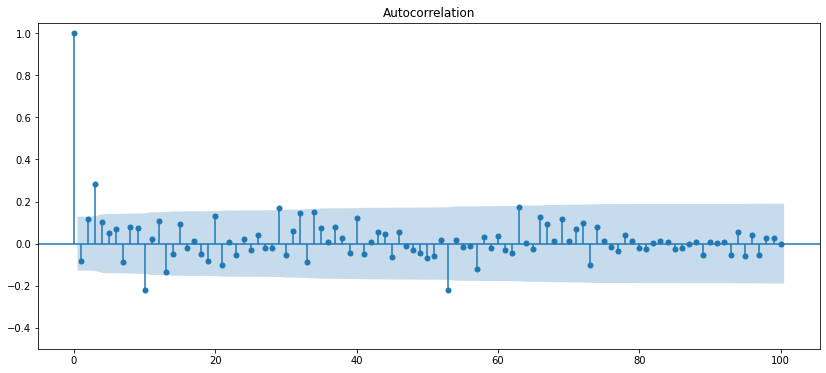

In [14]:
# Check ACF(Autocorrelation)
fig,ax=plt.subplots(figsize=(14,6))
plot_acf(df.first_diff.dropna(),ax=ax,lags=100);
plt.ylim([-0.5,1.05]);

Since series does not pass both tests, we can say that its not stationary.

Split the data in (70%,20%,10%) for the training, validation and test sets. Data is not shuffled before splitting. Because it ensures windows of consecutive samples is still possible and validation/test data looks more realistic.

In [15]:
df.drop(['first_diff'],axis=1,inplace=True)

In [16]:
df.head()

,MSPUS
DATE,
1963-01-01,17800.0
1963-04-01,18000.0
1963-07-01,17900.0
1963-10-01,18500.0
1964-01-01,18500.0


In [17]:
n=len(df)
train_df=df[0:int(n*0.7)]
val_df=df[int(n*0.7):int(n*0.9)]
test_df=df[int(n*0.9):]
num_features=df.shape[1]
test_df[-3:]


,MSPUS
DATE,
2021-07-01,411200.0
2021-10-01,423600.0
2022-01-01,428700.0


###Normalize the data
It is importnat to scale features before training a neural network. Normalization=subtract mean from data and divide by  standard deviation.
Normalization is done only using the training data to preven peeking into validation or test data.

In [18]:
train_mean=train_df['MSPUS'].mean()
train_std=train_df['MSPUS'].std()

train_df=(train_df-train_mean)/train_std
val_df=(val_df-train_mean)/train_std
test_df=(test_df-train_mean)/train_std

print(train_mean)
print(train_std)

85887.27272727272
54354.58241686483


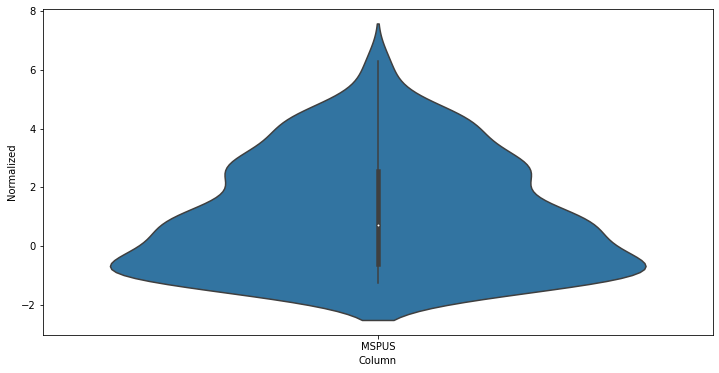

In [19]:
# Check the distribution of price feature. This code is useful even if data has more features
df_std=(df-train_mean)/train_std
df_std=df_std.melt(var_name='Column',value_name='Normalized')
plt.figure(figsize=(12,6))
ax=sns.violinplot(x='Column',y ='Normalized',data=df_std)


Windowing Data
We will use window of consecutive samples from the data to predict multiple time point in future.
Create WindowGenerator class to create windows as required.
This class makes winodws of trainaing, validation and test Dataframes. The data will be converted to tf.data.Dataset of windows.

In [20]:

# make windowed data using past values and future labels with shift parameter
def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

In [21]:
# Convert data into train, validation and test set to windowed dataset
train_set = windowed_dataset(series=train_df, batch_size=32, n_past=10, n_future=10,shift=1)
valid_set = windowed_dataset(series=val_df, batch_size=32,
                                 n_past=10, n_future=10,
                                 shift=1)
test_set = windowed_dataset(series=test_df, batch_size=32,
                                 n_past=10, n_future=10,
                                 shift=1)

2022-07-11 03:35:03.003109: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
# Check shape of windowed data.
train_set.element_spec

(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))

In [23]:
# This data is batched into 32 examples of 10 datapoint of 1 feature(MSUPS)
# As we are trying to predict next 10 prices, the lable will also have same shape
for example_inputs, example_labels in train_set.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 10, 1)
Labels shape (batch, time, features): (32, 10, 1)


2022-07-11 03:35:03.249863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [24]:
# Check 1 element in train data
for element in train_set:
  print(element)
  import sys
  sys.exit()

(<tf.Tensor: shape=(32, 10, 1), dtype=float64, numpy=
array([[[-1.25265009],
        [-1.24897055],
        [-1.25081032],
        [-1.23977169],
        [-1.23977169],
        [-1.23241261],
        [-1.23241261],
        [-1.22321375],
        [-1.20849558],
        [-1.21585467]],

       [[-1.24897055],
        [-1.25081032],
        [-1.23977169],
        [-1.23977169],
        [-1.23241261],
        [-1.23241261],
        [-1.22321375],
        [-1.20849558],
        [-1.21585467],
        [-1.20849558]],

       [[-1.25081032],
        [-1.23977169],
        [-1.23977169],
        [-1.23241261],
        [-1.23241261],
        [-1.22321375],
        [-1.20849558],
        [-1.21585467],
        [-1.20849558],
        [-1.20665581]],

       [[-1.23977169],
        [-1.23977169],
        [-1.23241261],
        [-1.23241261],
        [-1.22321375],
        [-1.20849558],
        [-1.21585467],
        [-1.20849558],
        [-1.20665581],
        [-1.19377741]],

       [[-1.239771

SystemExit: 

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3560: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#Predict next 10 features based on past 10 features
# Create sequential model
model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape = (10, 1)),
        tf.keras.layers.LSTM(32, return_sequences=True),
        #tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(10)
        
    ])

In [ ]:
model.summary()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cvlog=tf.keras.callbacks.CSVLogger('his.csv')
model.compile(
               loss="mae", optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),metrics=[tf.metrics.MeanAbsoluteError()]
    )

In [ ]:
history=model.fit(
        train_set, epochs=20,validation_data=valid_set, callbacks=[ early_stopping, cvlog], verbose=1
    )

In [ ]:
import pandas as pd
his = pd.read_csv('his.csv') 
his.head()

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
model_preds = make_preds(model,
                           input_data=test_set)
model_preds[:1]

In [ ]:
# De standardize the data
model_preds=(model_preds*train_std)+train_mean
model_preds[:1]